#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from   google.colab import drive

In [ ]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!cd "/content/gdrive/MyDrive/SNA"

In [ ]:
path = "/content/gdrive/MyDrive/SNA/CA-AstroPh-train.txt"

#Importing train and test dataset

In [ ]:
with open("/content/gdrive/MyDrive/SNA/CA-AstroPh-train.txt") as f:
    fb_links = f.read().splitlines() 

with open("/content/gdrive/MyDrive/SNA/CA-AstroPh-test.txt") as f:
    fb_links_test = f.read().splitlines() 

In [ ]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []
for i in tqdm(fb_links):
  node_list_1.append(i.split(' ')[0])
  node_list_2.append(i.split(' ')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 178443/178443 [00:00<00:00, 821378.49it/s]


In [ ]:
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph()) #converting the data into graph

In [ ]:
#node_naman= list ( G.nodes())

In [ ]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2


# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G)

In [ ]:
list (G.neighbors("3")) #All the neighbours of node 3

['39920',
 '33641',
 '69228',
 '45616',
 '48190',
 '81823',
 '132933',
 '44501',
 '24908',
 '48090',
 '88577',
 '81840',
 '111983',
 '122938',
 '42853',
 '122926',
 '39491',
 '96743',
 '125045',
 '79722',
 '60423',
 '105363',
 '86824',
 '289',
 '88648',
 '107466',
 '109835',
 '60813',
 '18610',
 '22555',
 '111420',
 '52699',
 '49628',
 '93363',
 '54258',
 '85838',
 '94648',
 '53719',
 '116976',
 '124092',
 '104877']

#**Graph Properties**

In [ ]:
# print ("Number of cliques=",nx.number_of_cliques(G))
print ("Number of self loops=",nx.number_of_selfloops(G))

Number of self loops= 56


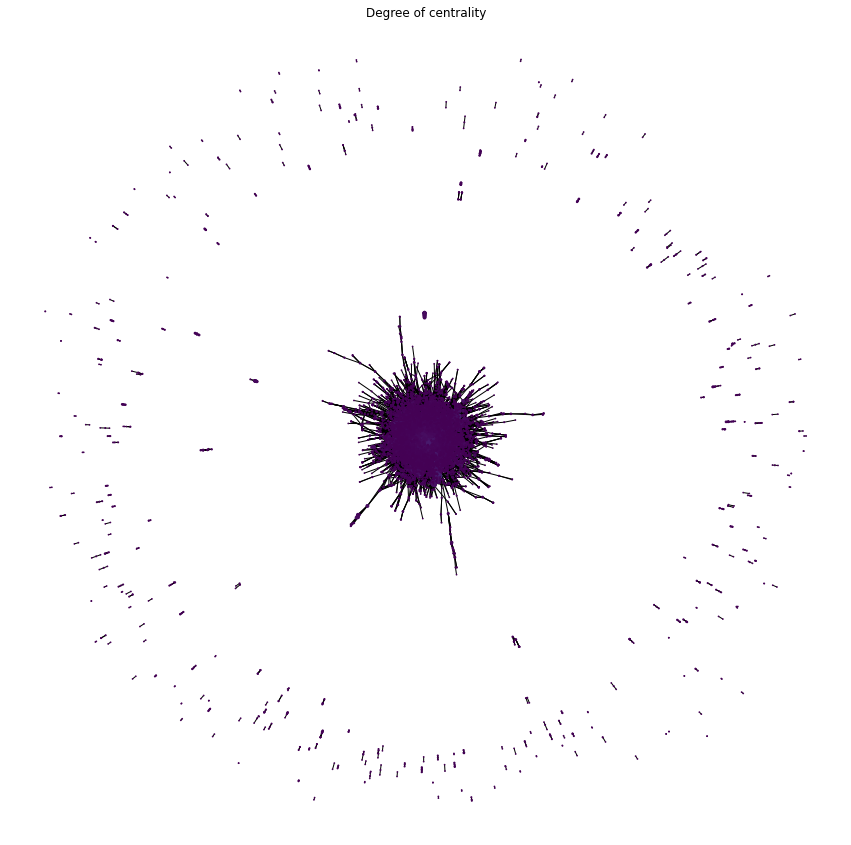

In [ ]:
pos = nx.spring_layout(G)
degCent = nx.degree_centrality(G) 
node_color = [20000.0 * G.degree(v) for v in G]
node_size = [v * 10000 for v in degCent.values()]
plt.figure(figsize=(15,15))
nx.draw_networkx(G, pos=pos, with_labels=False,node_color=node_color,node_size=node_size)
plt.axis("off")
plt.title( "Degree of centrality")
plt.show()


In [ ]:
cloCent = nx.closeness_centrality(G)
node_size = [v * 10000 for v in cloCent.values()]
plt.figure(figsize=(15,15))
nx.draw_networkx(G, pos=pos, with_labels=False,node_color=node_color,node_size=node_size)
plt.axis("off")
plt.title("Closeness Centrality")
plt.show()


In [ ]:
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_size = [v * 10000 for v in betCent.values()]
plt.figure(figsize=(15,15))
nx.draw_networkx(G, pos=pos, with_labels=False,node_color=node_color,node_size=node_size)
plt.axis("off")
plt.title("Betweeness Centrality")
plt.show()


##Degree of each node

In [ ]:
degree=[]
for i in node_list:
  deg= G.degree(i)
  degree.append(deg)

In [ ]:
print ("Number of componenets in the graph= ",nx.number_connected_components(G))
print ("Number of edges in the graph=",len (list (G.edges)))

Number of componenets in the graph=  282
Number of edges in the graph= 178443


#Preparing dummy data with no connection

In [ ]:
import random
found_node=[]
# get unconnected node-pairs
all_unconnected_pairs = []
random.seed=0
# traverse adjacency matrix
for i in tqdm(range(adj_G.shape[0])):
  requirement= degree[i]*3         
  found =0
  list_to_search=random. sample(range(0, adj_G.shape[0]), requirement*10)
  for j in list_to_search:
    if i==j:
      continue
    if adj_G[i,j] == 0:
      try:
        if nx.shortest_path_length(G, node_list[i], node_list[j]) >=4:
          all_unconnected_pairs.append([node_list[i],node_list[j]]  )    
          found+=1
      except:
        print("",end="")
    if (found >requirement):
      break


100%|██████████| 18616/18616 [06:36<00:00, 46.90it/s] 


In [ ]:
print ("No of unconnected nodes generated",len (all_unconnected_pairs))

No of unconnected nodes generated 1082677


In [ ]:
fb_df["link"]=1

#Dataframe for unconnected graph created

In [ ]:

node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [ ]:
final_dataset = fb_df.append(data[['node_1', 'node_2', 'link']], ignore_index=True)

In [ ]:
final_dataset["link"].value_counts()

0    1082677
1     178443
Name: link, dtype: int64

In [ ]:
fb_df["link"].value_counts()

1    178443
Name: link, dtype: int64

In [ ]:
initial_node_count = len(G.nodes)

In [ ]:
G_final_data = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

In [ ]:
len (G_final_data.edges)

178443

#**Node2vec- Calculating the feature space from the graph**

In [ ]:
!pip install node2vec

In [ ]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_final_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [17:18<00:00, 20.78s/it]


In [ ]:
n2w_model.most_similar("3")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('124092', 0.9511211514472961),
 ('69228', 0.9506341218948364),
 ('48190', 0.9475717544555664),
 ('111420', 0.9471034407615662),
 ('53719', 0.9470353126525879),
 ('81823', 0.9448241591453552),
 ('85838', 0.9435477256774902),
 ('39491', 0.943482518196106),
 ('81840', 0.9402889013290405),
 ('14354', 0.9395026564598083)]

#**Final dataset balance**

In [ ]:
#nx.number_of_cliques(G_final_data)
final_dataset["link"].value_counts()

0    1082677
1     178443
Name: link, dtype: int64

#**Calculating feature values for each node**

In [ ]:
x = [(n2w_model[i]+n2w_model[j]) for i,j in zip(final_dataset['node_1'], final_dataset['node_2'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
print ("\t\t\tEmbedding of Node",node_list[0], "\n",x[0])

			Embedding of Node 70718 
 [-0.8396269  -0.3383903  -1.4534988  -2.0951457  -1.7077727  -0.28208953
 -0.50800794 -0.16813874 -0.56951374  0.13483049 -0.42126548 -1.6664457
 -0.59187806 -0.9663906  -0.5548525   1.33477     0.42624077 -0.78879607
 -0.49857485 -2.1055336   0.57379866  0.91817105  0.8654206   0.18371966
  0.7194607   0.39413548 -0.6523372  -0.36365065 -0.6031277  -0.5235122
  1.5665679   1.0652068  -0.5820079  -0.37059295 -1.6724473   0.20088176
 -1.121522    1.1875961   0.20666628  1.1072322   2.2512512  -0.01148426
  0.11683507 -0.3893227  -0.10946038  2.1255865   0.7216568  -0.02862898
  0.29751992 -0.02389446 -1.2896621  -0.30111617  1.8088119   1.2296716
  1.3281698   0.30918074  0.8640597   1.3221458  -0.7457082   0.23568177
 -0.8623277   0.51676226 -0.4222242  -1.3224814   0.62942684 -0.952767
 -0.3744905  -0.51516855 -0.67444706 -0.06295997 -0.5767625  -1.357805
 -1.0188975  -1.3457744   0.04282556 -0.3708102  -0.45288154 -0.6929661
 -1.8937439   0.34712002  1.56

#Splitting the data  on the Train Dataset

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), final_dataset['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

#Preparing the Test data

In [ ]:
df_test=pd.DataFrame()
# Test data 
# captture nodes in 2 separate lists
node_list_1_test = []
node_list_2_test = []
for i in tqdm(fb_links_test):
  node_list_1_test.append(i.split(' ')[0])
  node_list_2_test.append(i.split(' ')[1])

fb_df_test = pd.DataFrame({'node_1': node_list_1_test, 'node_2': node_list_2_test})
df_test["node_1"]= node_list_1_test
df_test["node_2"]= node_list_2_test


100%|██████████| 19667/19667 [00:00<00:00, 679327.48it/s]


In [ ]:
index_drop=[]
for i in range( len (df_test["node_1"])):
  if df_test["node_1"][i] not in node_list:
    index_drop.append(i)
    continue
  if df_test["node_2"][i] not in node_list:
    index_drop.append(i)

In [ ]:
df_final_test= df_test.drop( index=index_drop)
x_test = [(n2w_model[i]+n2w_model[j]) for i,j in zip(df_final_test["node_1"], df_final_test["node_2"])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


#**Logistic Regression**

In [ ]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lr.predict_proba(xtest)
roc_auc_score(ytest, predictions[:,1])

0.7806242627830651

#Logistic Regression on test data

In [ ]:
prediction= lr.predict(x_test)
accuracy_matrix=np.unique(prediction, return_counts=True)
accuracy_lr= (accuracy_matrix[1][1]/((accuracy_matrix[1][0]+accuracy_matrix[1][1])))
print("Accuracy of the Logistic regression model on test data set",100*np.round(accuracy_lr,4))

Accuracy of the Logistic regression model on test data set 74.32


#**Nueral Network model** 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature # This pacakge is used for LBP feature extraction
from sklearn import svm # This pacakge is used for svm classification
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score
%matplotlib inline
import cv2
import seaborn as sns # This pacakge is used for better visualization of data (e.g confusion matrix)
import pandas as pd
from keras.datasets import mnist
import tensorflow as tf

In [ ]:
model= tf.keras.models.Sequential(  [ 
                                      tf.keras.layers.Flatten( input_shape= [100,1]),
                                      tf.keras.layers.Dense(512, activation=tf.nn.relu),     
                                      tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                      tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                      ]
                                    )

In [ ]:
model.compile( optimizer=tf.optimizers.SGD(learning_rate=0.001)  , loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [ ]:
model.fit( xtrain, ytrain, epochs=10, batch_size=32)

Epoch 1/10
27587/27587 [==============================] - 51s 2ms/step - loss: 0.3355 - accuracy: 0.8717
Epoch 2/10
27587/27587 [==============================] - 49s 2ms/step - loss: 0.0917 - accuracy: 0.9833
Epoch 3/10
27587/27587 [==============================] - 49s 2ms/step - loss: 0.0368 - accuracy: 0.9942
Epoch 4/10
27587/27587 [==============================] - 49s 2ms/step - loss: 0.0233 - accuracy: 0.9958
Epoch 5/10
27587/27587 [==============================] - 49s 2ms/step - loss: 0.0177 - accuracy: 0.9968
Epoch 6/10
27587/27587 [==============================] - 49s 2ms/step - loss: 0.0142 - accuracy: 0.9973
Epoch 7/10
27587/27587 [==============================] - 49s 2ms/step - loss: 0.0119 - accuracy: 0.9976
Epoch 8/10
27587/27587 [==============================] - 49s 2ms/step - loss: 0.0104 - accuracy: 0.9979
Epoch 9/10
27587/27587 [==============================] - 49s 2ms/step - loss: 0.0094 - accuracy: 0.9981
Epoch 10/10
27587/27587 [==============================

In [ ]:
accuracy=model.evaluate(xtest,ytest)
print("Accuracy of the model-",'\033[1m'+ str (100*np.round(accuracy[1],4))+"%"+'\033[0m')

11823/11823 [==============================] - 18s 2ms/step - loss: 0.0085 - accuracy: 0.9981
Accuracy of the model- 99.81%


#Nueral network Accuracy on Test Dataset

In [ ]:
prediction=model.predict_classes( np.reshape(x_test, [19516,100,1]))
accuracy_matrix=np.unique(prediction, return_counts=True)
accuracy_ann= (accuracy_matrix[1][1]/((accuracy_matrix[1][0]+accuracy_matrix[1][1])))

In [ ]:
print("Accuracy of the model on test data set",'\033[1m'+ str (100*np.round(accuracy_ann,4))+"%"+'\033[0m')

Accuracy of the model on test data set 93.44%


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 84,609
Trainable params: 84,609
Non-trainable params: 0
_________________________________________________________________


#**Jaccard**

In [ ]:
jaccard_list=[]
for i in range( len (final_dataset)):
  v=nx.jaccard_coefficient( G,[(  final_dataset["node_1"][i],final_dataset["node_2"][i])])
  for a,b,c in v:
    jaccard_list.append(c)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(jaccard_list, final_dataset['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [ ]:
model= tf.keras.models.Sequential(  [ 
                                      tf.keras.layers.Flatten( input_shape= [1,1]),
                                      tf.keras.layers.Dense(512, activation=tf.nn.relu),     
                                      tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                      tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                      ]
                                    )

In [ ]:
model.compile( optimizer=tf.optimizers.SGD(learning_rate=0.001)  , loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [ ]:
model.fit( xtrain, list (ytrain), epochs=10, batch_size=32)

Epoch 1/10
27587/27587 [==============================] - 47s 2ms/step - loss: 0.4547 - accuracy: 0.8588
Epoch 2/10
27587/27587 [==============================] - 47s 2ms/step - loss: 0.2944 - accuracy: 0.8839
Epoch 3/10
27587/27587 [==============================] - 48s 2ms/step - loss: 0.1607 - accuracy: 0.9424
Epoch 4/10
27587/27587 [==============================] - 47s 2ms/step - loss: 0.1042 - accuracy: 0.9653
Epoch 5/10
27587/27587 [==============================] - 47s 2ms/step - loss: 0.0785 - accuracy: 0.9750
Epoch 6/10
27587/27587 [==============================] - 47s 2ms/step - loss: 0.0641 - accuracy: 0.9806
Epoch 7/10
27587/27587 [==============================] - 47s 2ms/step - loss: 0.0555 - accuracy: 0.9836
Epoch 8/10
27587/27587 [==============================] - 47s 2ms/step - loss: 0.0492 - accuracy: 0.9861
Epoch 9/10
27587/27587 [==============================] - 48s 2ms/step - loss: 0.0449 - accuracy: 0.9877
Epoch 10/10
27587/27587 [==============================

In [ ]:
accuracy=model.evaluate(xtest,list (ytest))
print("Accuracy of the model-",'\033[1m'+ str (100*np.round(accuracy[1],4))+"%"+'\033[0m')

11823/11823 [==============================] - 17s 1ms/step - loss: 0.0396 - accuracy: 0.9890
Accuracy of the model- 98.9%


In [ ]:
jaccard_list_test=[]
for i in df_final_test.index:
  v= nx.jaccard_coefficient( G,[( df_final_test["node_1"][i],df_final_test["node_2"][i])])
  for a,b,c in v:
    jaccard_list_test.append(c)
  #  print(c)


In [ ]:
prediction=model.predict_classes( np.reshape(jaccard_list_test, [19516,1,1]))
accuracy_matrix=np.unique(prediction, return_counts=True)
accuracy_ann= (accuracy_matrix[1][1]/((accuracy_matrix[1][0]+accuracy_matrix[1][1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print("Accuracy of the model on test data set",'\033[1m'+ str (100*np.round(accuracy_ann,4))+"%"+'\033[0m')

Accuracy of the model on test data set 92.73%


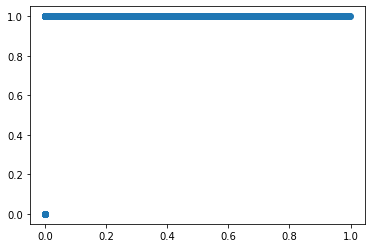

In [ ]:
plt.scatter( jaccard_list, list (final_dataset['link']),cmap="viridis")